In [2]:
import os
import numpy as np
from scipy.io.wavfile import read as waveread
import pysptk
from functools import cached_property
import librosa
from agc import tf_agc

import matplotlib.pyplot as plt


FRAME_LENGTH = 1024
HOP = 80
ORDER = 25
ALPHA = 0.41 # TODO: find alpha for 441000 Hz

class VowelRecording:
    def __init__(self, filepath):
        self.filepath = filepath
        self.wav = waveread(filepath)
        
        self.fs = self.wav[0]
        self._data = np.array(self.wav[1], dtype=np.float64)
        
        self.is_stereo = self.wav[1].ndim == 2
        self.mono = self._mid if self.is_stereo else self._data

    @cached_property
    def mono_agc(self):
        """ normalize loudness so that all vowels sections are comparable """
        y, _, _ = tf_agc(self.mono, self.fs)
        return y

    @cached_property
    def _frames(self):
        # Note that almost all of pysptk functions assume input array is C-contiguous and np.float64 element type
        frames = librosa.util.frame(self.mono_agc, frame_length=FRAME_LENGTH, hop_length=HOP).astype(np.float64).T
        
        # Windowing
        frames *= pysptk.blackman(FRAME_LENGTH)
        
        return frames

    
    @cached_property
    def mcep(self):
        return pysptk.sptk.mcep(self._frames, order=ORDER, alpha=ALPHA)

    
    @cached_property
    def mfcc(self):
        return pysptk.sptk.mfcc(self.mono_agc, fs=self.fs)


    @cached_property
    def short_term_mfcc(self):
        return [pysptk.sptk.mfcc(frame, fs=self.fs) for frame in self._frames]

    
    @cached_property
    def running_mfcc(self):
        return np.array([pysptk.sptk.mfcc(frame, fs=self.fs) for frame in self._frames])

        
    @property
    def _left(self):
        return self._data[:,0] if self.is_stereo else self._data         

    
    @property
    def _right(self):
        return self._data[:,1] if self.is_stereo else self._data         

    
    @property
    def _mid(self):
        return (self._left + self._right) / 2.0 if self.is_stereo else self._data

    
    @property
    def _side(self):
        return (self._left - self._right) / 2.0 if self.is_stereo else np.zeros(self._data.shape)

        
class SynthesizedVowel(VowelRecording):
    def __init__(self, filepath):
        VowelRecording.__init__(self, filepath)
        
        s = os.path.basename(filepath).split('.')[0].split('_')
        self.vowel = s[0]
        self.bloc = s[1]
        self.repetition = s[3]
        assist_string = s[5]
        self.assist = 1 if assist_string == '1' else float(assist_string)/10.0


class TruthVowel(VowelRecording):
    def __init__(self, filepath):
        VowelRecording.__init__(self, filepath)

        filename_without_ext = os.path.basename(filepath).split('.')[0]
        self.vowel = filename_without_ext


        

# get complete vowels files
complete_synthesis_path = 'static/data/P5_D4_RT_003_cam_complete_synthesis/'

waves_paths = [os.path.join(complete_synthesis_path, f) for f in os.listdir(complete_synthesis_path)]
waves_paths = [w for w in waves_paths if os.path.isfile(w)] 
synthesis = [SynthesizedVowel(path) for path in waves_paths]
        

# match them with the corresponding by vowels
by_vowels_path = 'static/data/P5_D4_RT_003_cam_complete_synthesis/truth/'

waves_paths = [os.path.join(by_vowels_path, f) for f in os.listdir(by_vowels_path)]
truth = [TruthVowel(path) for path in waves_paths]


# plt.plot(synthesis[0].running_mfcc)

Text(0.5, 1.0, 'mono synthesis (not normalized)')

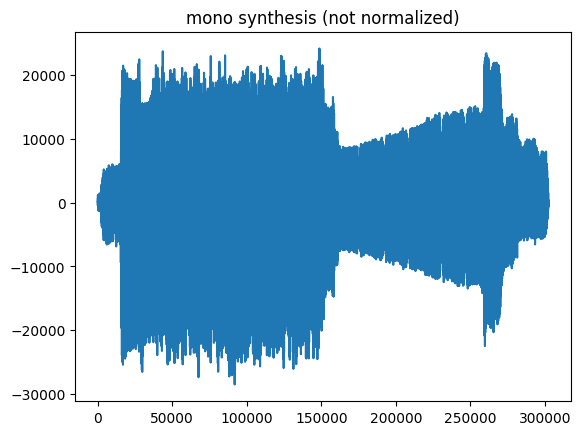

In [3]:
plt.plot(synthesis[0].mono)
plt.title('mono synthesis (not normalized)')

Text(0.5, 1.0, 'mono synthesis normalized by agc')

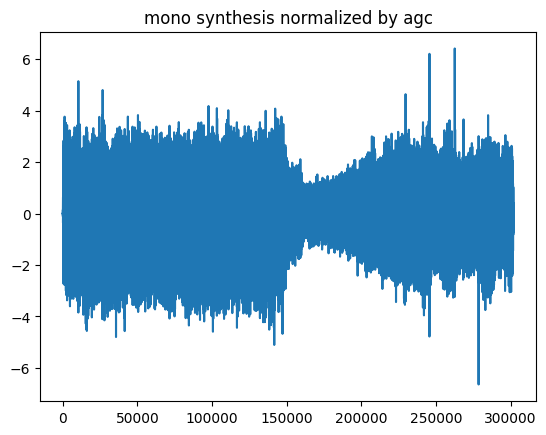

In [4]:
plt.plot(synthesis[0].mono_agc)
plt.title('mono synthesis normalized by agc')

fft : m must be a integer of power of 2!


Text(0.5, 1.0, 'synthesis mfcc (on normalized signal)')

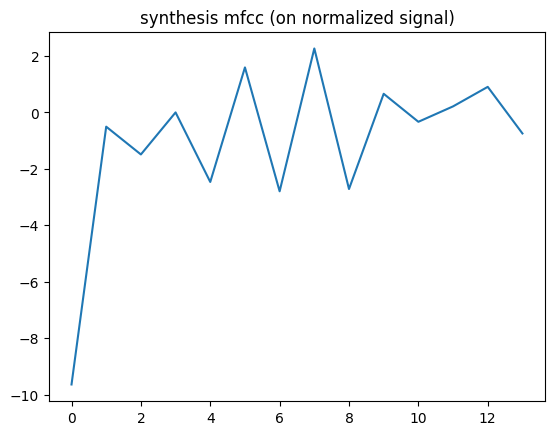

In [5]:
plt.plot(synthesis[0].mfcc)
plt.title('synthesis mfcc (on normalized signal)')

Text(0.5, 1.0, 'mono truth (not normalized)')

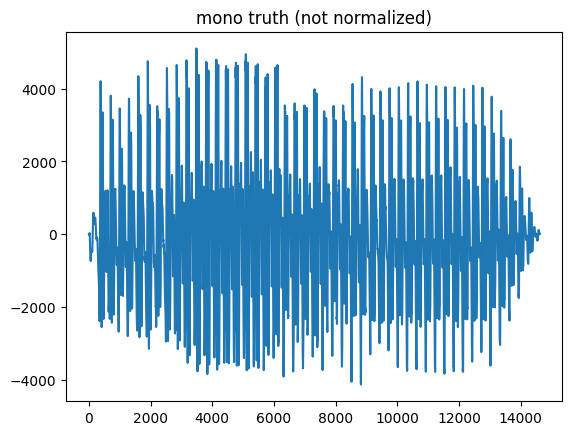

In [6]:
plt.plot(truth[0].mono)
plt.title('mono truth (not normalized)')

Text(0.5, 1.0, 'mono truth normalized by agc')

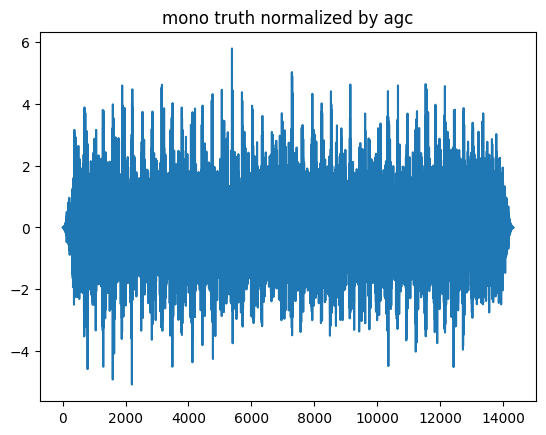

In [7]:
plt.plot(truth[0].mono_agc)
plt.title('mono truth normalized by agc')

fft : m must be a integer of power of 2!


Text(0.5, 1.0, 'truth mfcc (on normalized signal)')

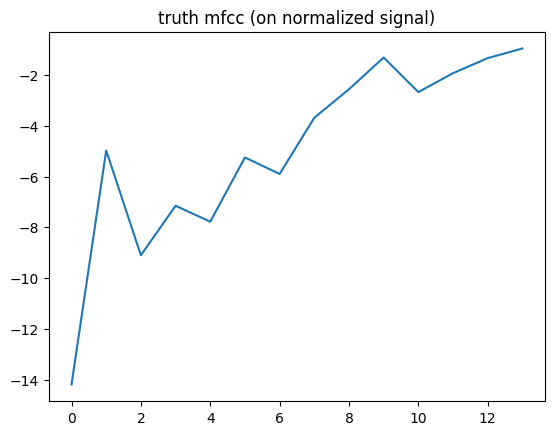

In [8]:
plt.plot(truth[0].mfcc)
plt.title('truth mfcc (on normalized signal)')

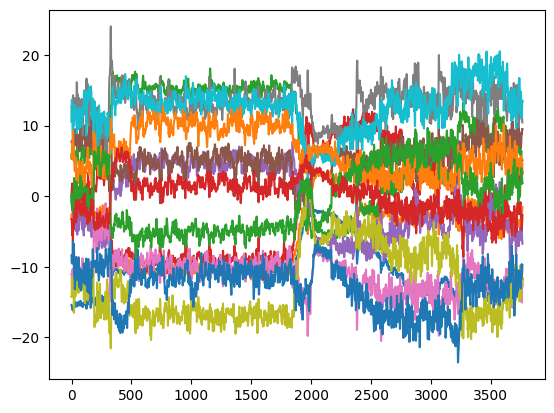

In [9]:
plt.plot(synthesis[0].short_term_mfcc)

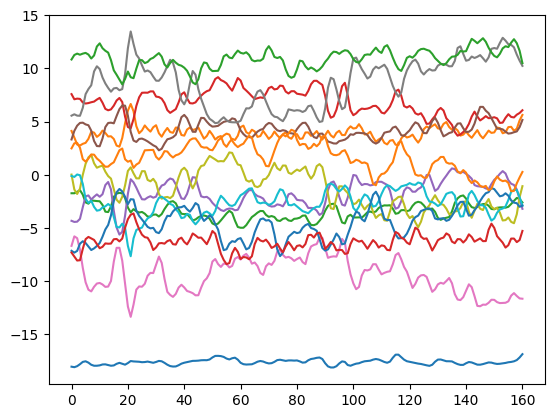

In [10]:
plt.plot(truth[1].short_term_mfcc)

fft : m must be a integer of power of 2!


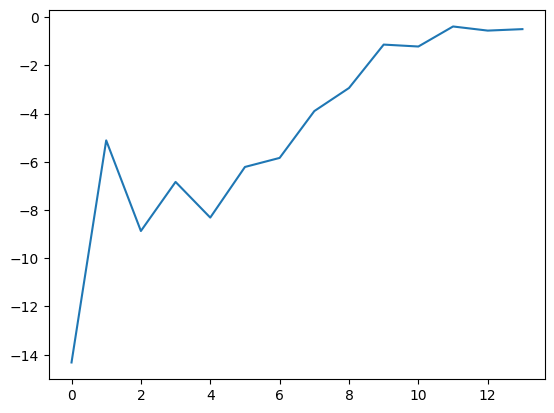

In [11]:
plt.plot(truth[1].mfcc)

In [12]:
from dtw import dtw

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [31]:
def short_term_dtw_distance(query, template):
    n_truth = len(template)
    n_synth = len(query)
    offset = n_synth % n_truth # remove first samples so all windows have the same length, otherwise the distance will be biased
    queries = (query[i:i+n_truth] for i in range(offset, n_synth, n_truth))
    distances = []
    for q in queries:
        alignment = dtw(q, template, keep_internals=True)
        distances.append(alignment.distance)
    return distances

def plot_distances(synth, truth, distances, title='', distance_label=''):
    fig, axs = plt.subplots(3,1)
    axs[0].plot(distances)
    axs[0].set_ylabel(distance_label)
    axs[1].plot(synth.mono_agc)
    axs[1].set_ylabel('synth')
    axs[2].plot(truth.mono_agc)
    axs[2].set_ylabel('truth')
    fig.suptitle(title)
    return fig, axs

def find_truth(synth):
    for t in truth:
        if t.vowel == synth.vowel:
            return t
    raise Error(f'truth vowel corresponding to  {synth} not found') # should always return before



## Compute distances with DTW
+ compute mfcc of truth and synthesis on frames (hop=80)
+ split synthesis in chunks of length equal to truth (throw modulo at the beginning to avoid bias at the end which is more important)
+ compute dtw distance between truth and each chunks of synthesis
+ plot the distances
+ a downward tendency should mean improvement from either the machine or the patient

_**For DTW, cite:**_ 
> Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package. J. Stat. Soft., 31 (2009) doi:10.18637/jss.v031.i07.


/tmp/ipykernel_10495/2297955036.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3,1)


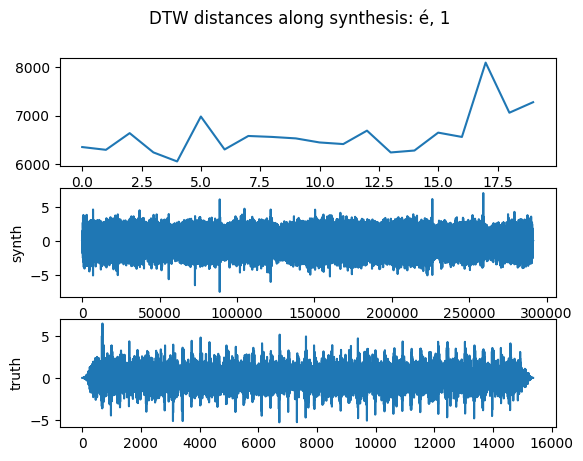

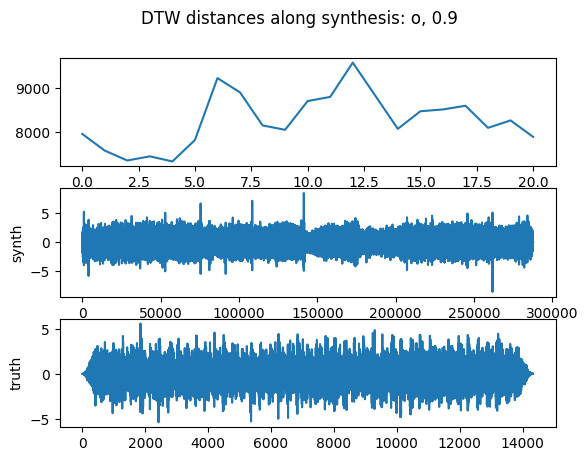

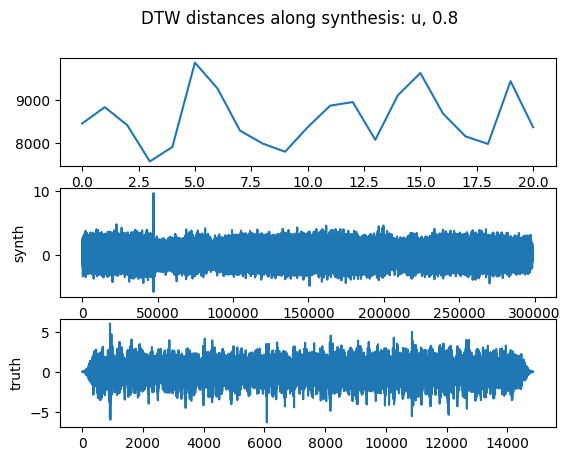

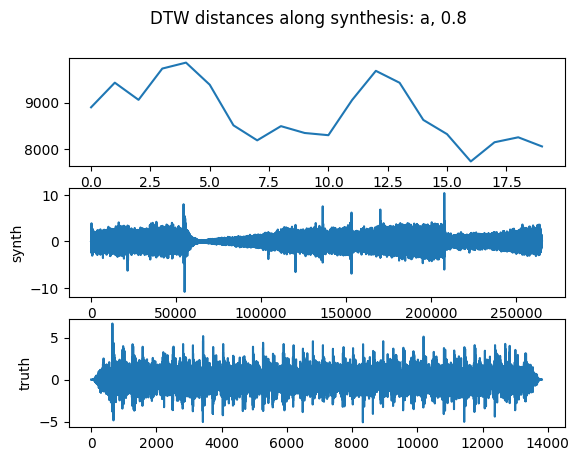

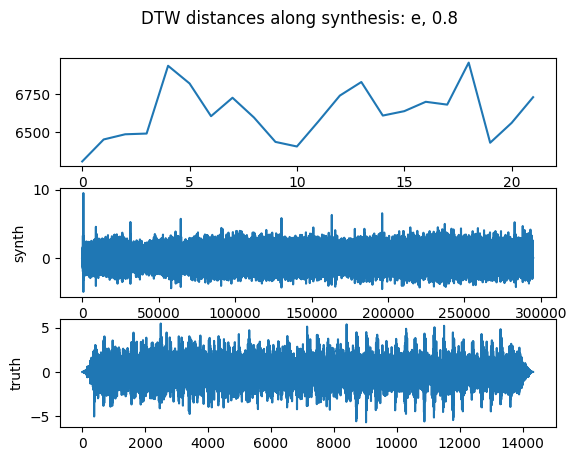

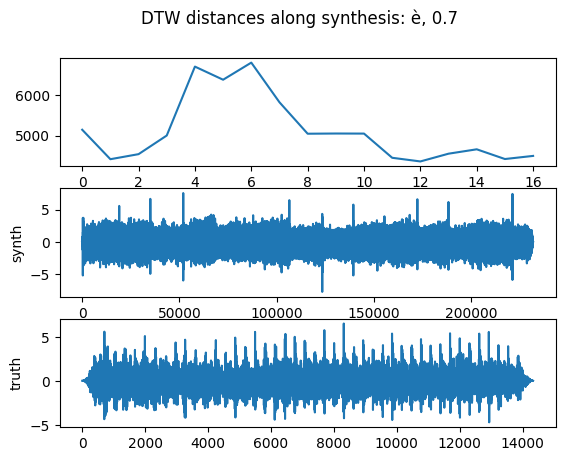

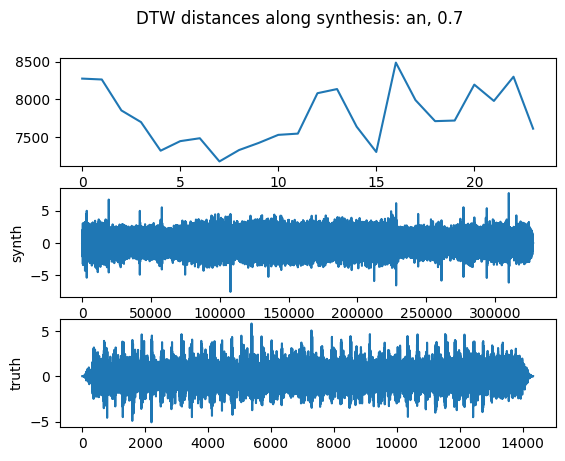

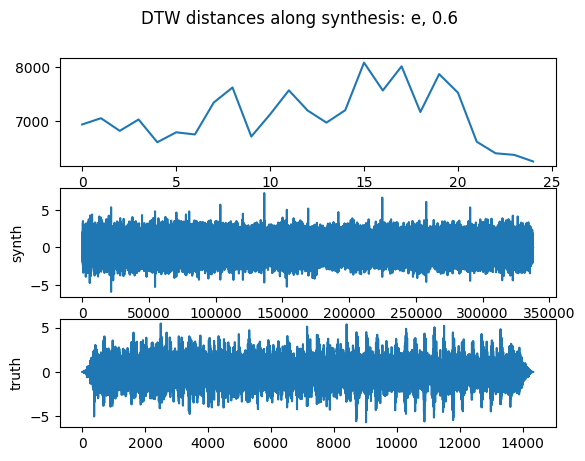

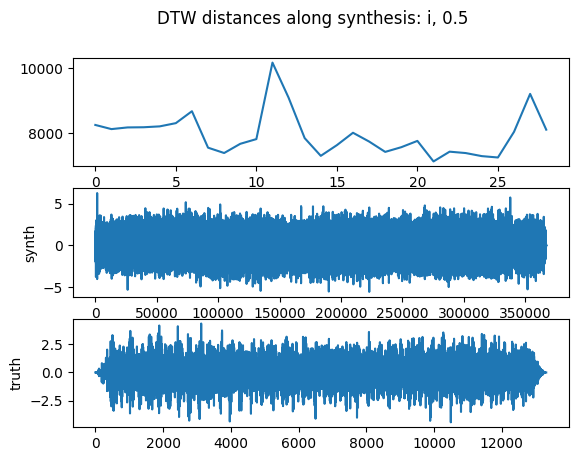

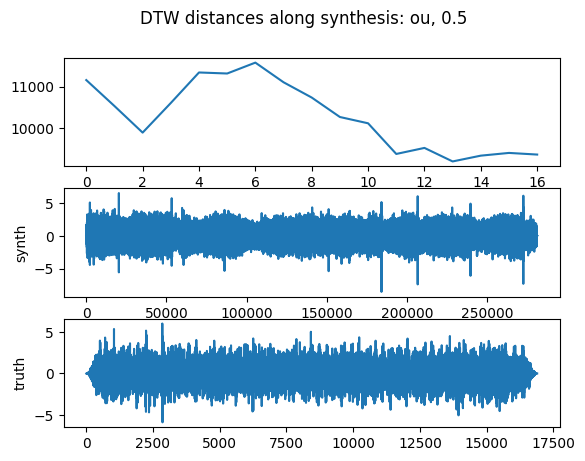

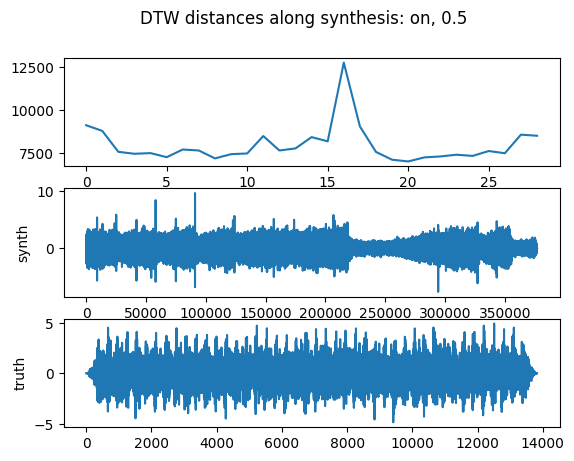

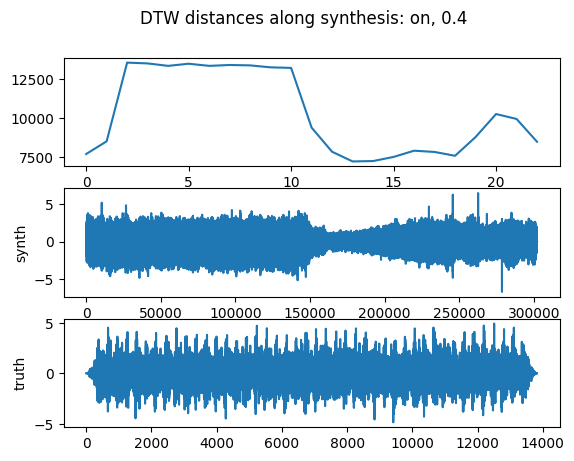

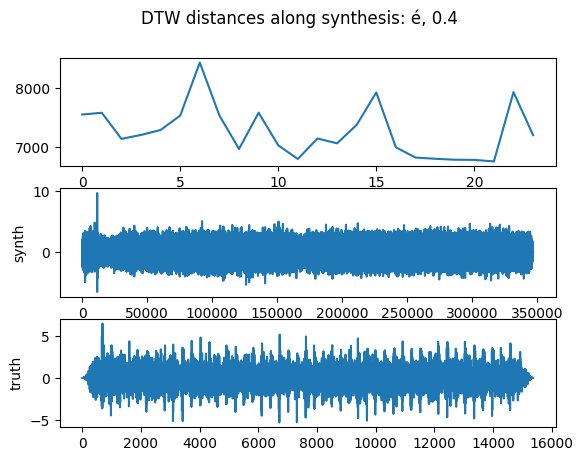

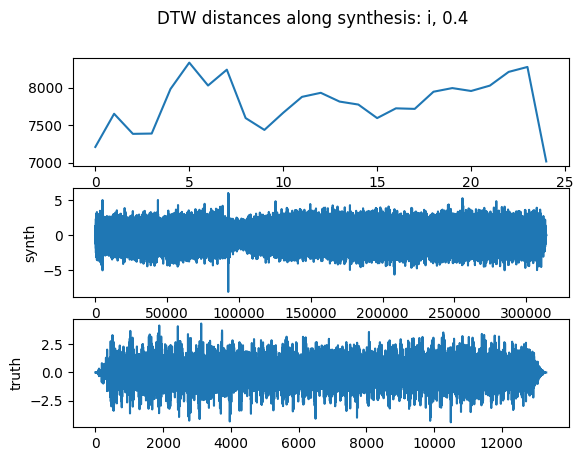

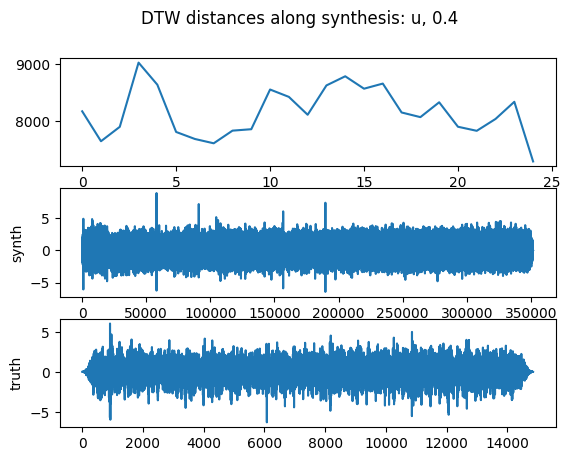

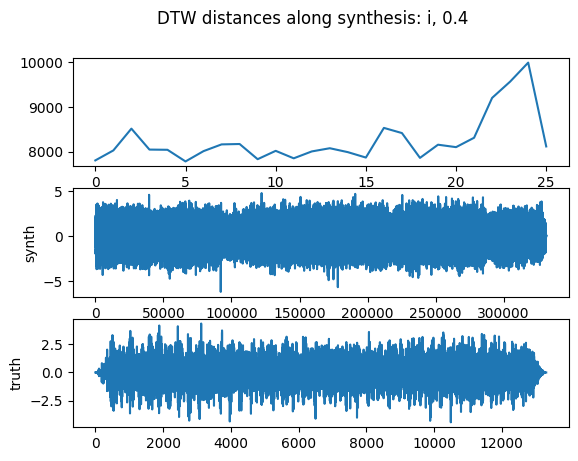

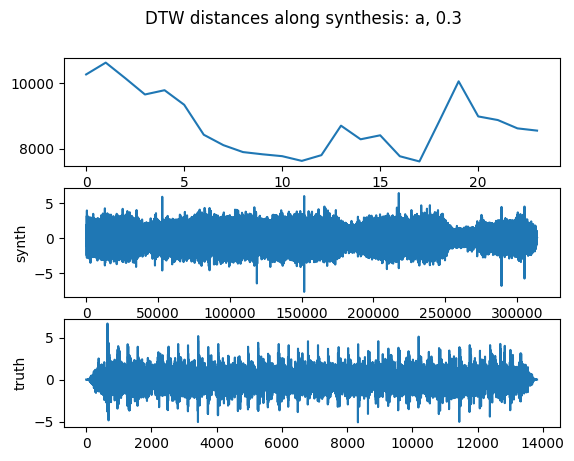

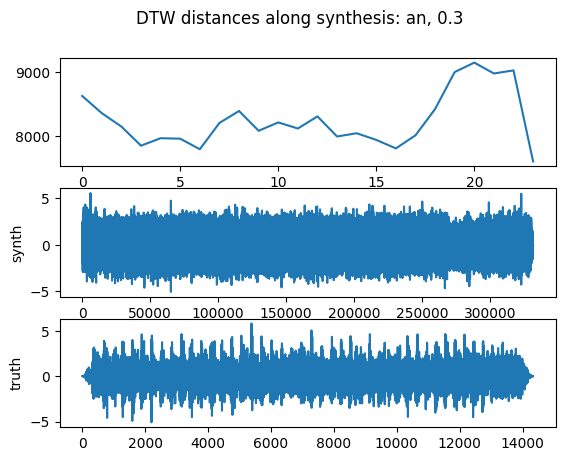

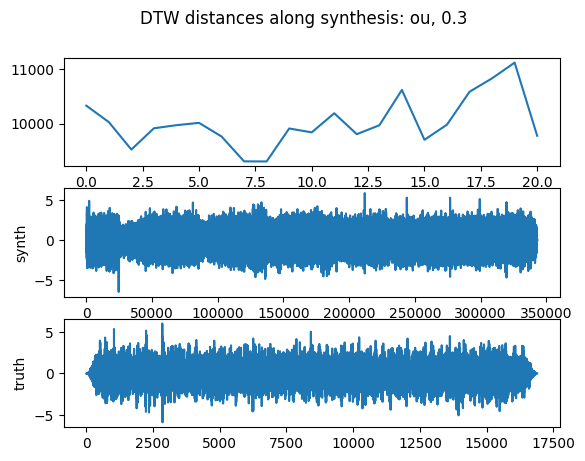

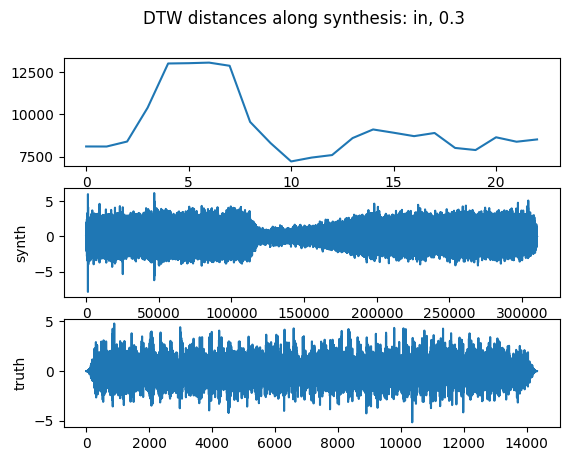

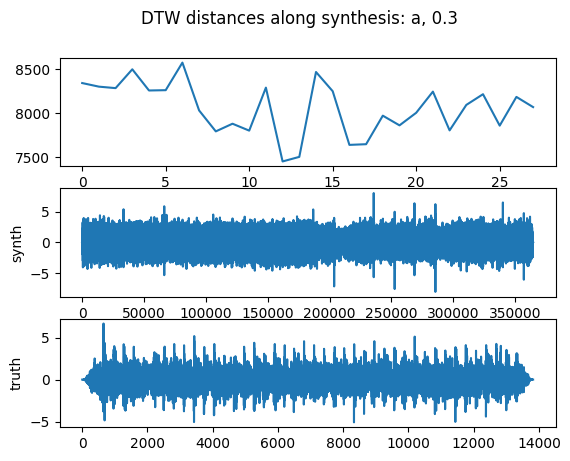

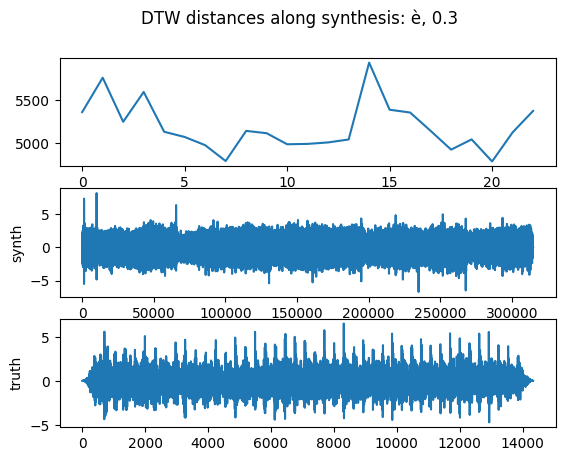

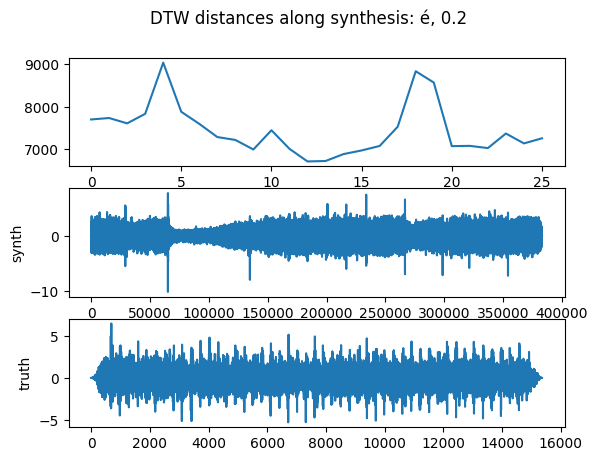

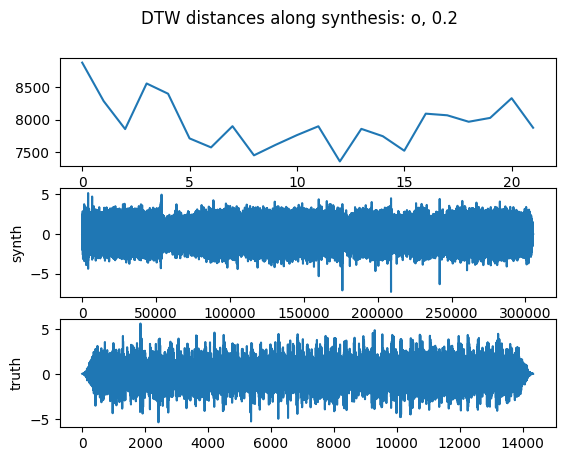

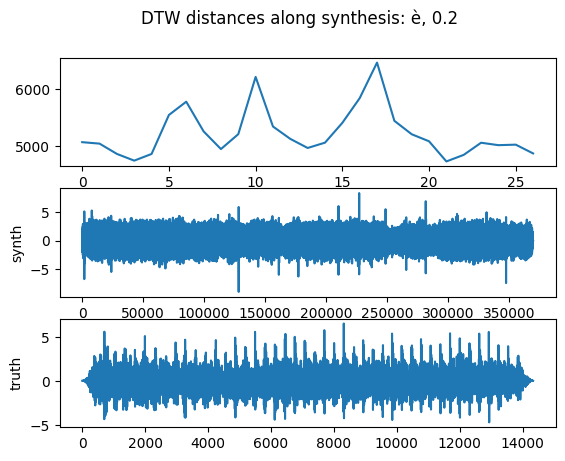

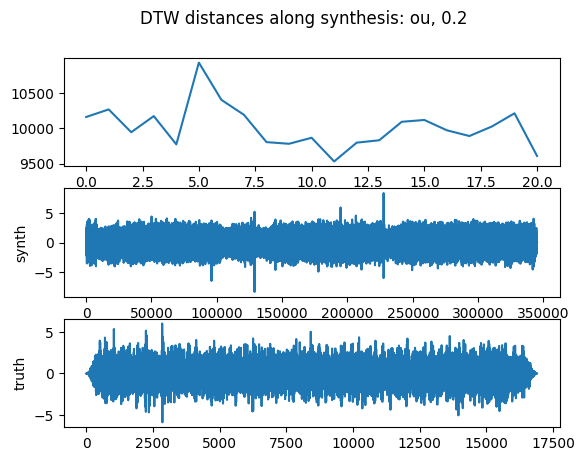

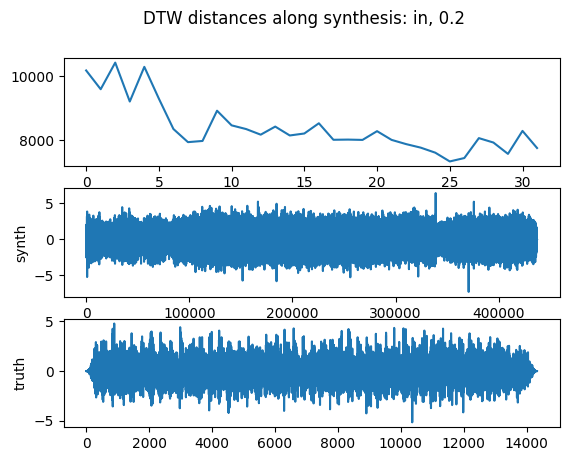

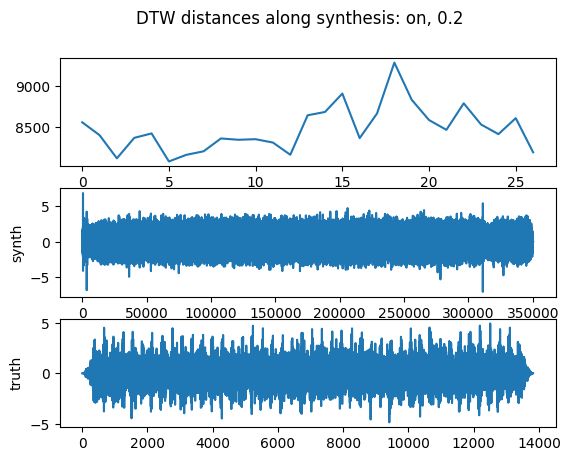

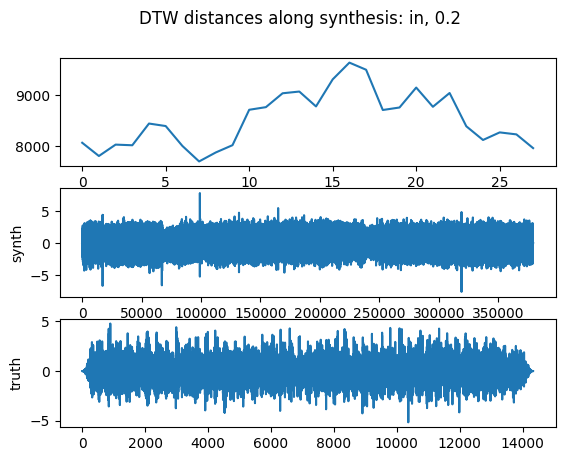

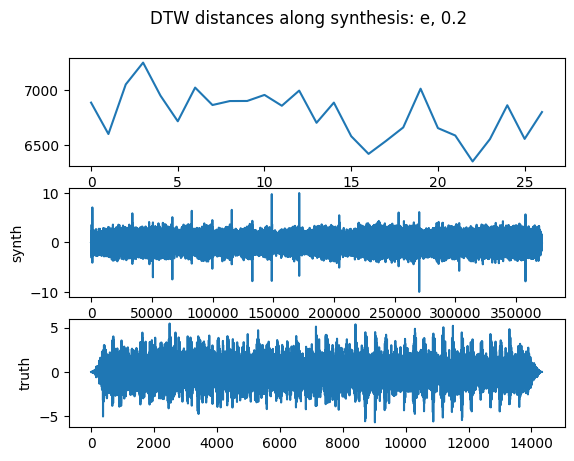

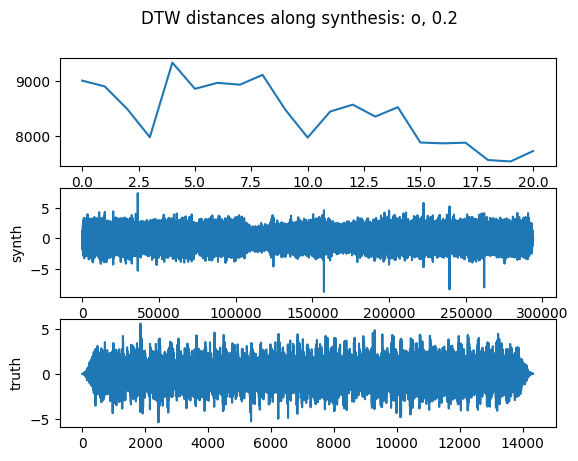

In [14]:
# dtw distances

trials = []
for synth in sorted(synthesis, key=lambda x: x.assist, reverse=True):
    ground_truth = find_truth(synth)
    distances = short_term_dtw_distance(synth.short_term_mfcc, ground_truth.short_term_mfcc)
    trials.append(distances)
    plot_distances(synth, ground_truth, distances,
                   title=f'DTW distances along synthesis: {synth.vowel}, {synth.assist}',
                   distance_label='DTW')

In [15]:
trial_begin = [t[:5] for t in trials]
trial_end = [t[-5:] for t in trials]
print(np.mean(trial_begin))
print(np.mean(trial_end))

8145.516909185088
7829.745760948333


In [26]:
len(trials[4])

22

regression coefficient: [0.00247119]
regression coefficient: [0.00251686]


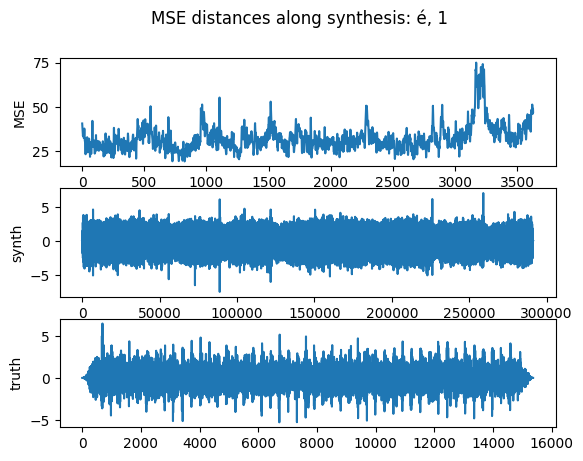

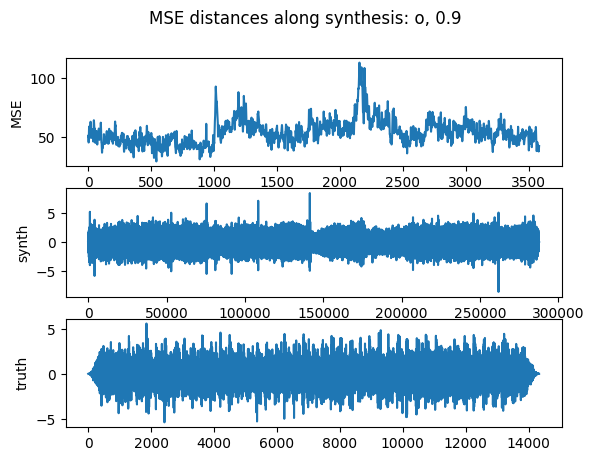

In [50]:
# mse distance to mean truth mfcc

from sklearn.linear_model import LinearRegression

reg = LinearRegression()


def mse(x,y, axis=0):
    return np.mean((x-y)**2, axis=axis)

def mse_to_mean(synth, truth):
    truth_mean = np.mean(truth.short_term_mfcc, axis=0)
    return [mse(m, truth_mean) for m in synth.short_term_mfcc]

mse_to_mean_distances = {}
for synth in sorted(synthesis, key=lambda x: x.assist, reverse=True)[:2]:
    ground_truth = find_truth(synth)
    distances = mse_to_mean(synth, ground_truth)
    
    reg.fit(np.arange(len(distances)).reshape(-1,1), distances)
    print(f'regression coefficient: {reg.coef_}')
    
    mse_to_mean_distances[synth] = distances
    plot_distances(synth, ground_truth, distances,
                   title=f'MSE distances along synthesis: {synth.vowel}, {synth.assist}',
                   distance_label='MSE')

#### mfcc of the whole sound and mean of short term mfcc are not the same

In [48]:
d = mse_to_mean_distances[sorted(synthesis, key=lambda x: x.assist, reverse=True)[0]]

reg.fit(np.arange(len(d)).reshape(-1,1), d)
reg.coef_

array([0.00247119])

In [96]:
print( np.mean(truth[0].short_term_mfcc, axis=0) )
print( truth[0].mfcc )

[-17.25305172   2.99814918  -1.55738615   6.95109411  -3.57332739
   6.9128524  -12.00639422   8.58142024  -5.50826052   3.84257672
  -0.03820474  -7.56149404  12.57348333  -2.82541409]
[-14.19374059  -4.97622821  -9.10122385  -7.15240651  -7.78018189
  -5.24899254  -5.89981109  -3.68416929  -2.56181712  -1.31025137
  -2.67354206  -1.92888539  -1.33548916  -0.95542779]


In [1]:
np.square(synthesis[0].short_term_mfcc - truth[0].mfcc, axis=0).mean()

NameError: name 'np' is not defined